# Image Captioning with LLaVA: Evaluation and Analysis

This notebook demonstrates how to use the LLaVA model for image captioning and evaluates its performance using various metrics.

Visual Language Models (VLMs) are a class of AI models that combine the capabilities of computer vision and natural language processing. They are designed to understand and generate content that involves both images and text, enabling tasks like image captioning, visual question answering, and text-to-image generation.

LLaVA (Large Language and Vision Assistant) is a prominent VLM, and LLaVA 7b refers to a version of this model with 7 billion parameters. LLaVA models are trained on a large dataset of image-text pairs, allowing them to learn the intricate relationships between visual elements and linguistic descriptions. This makes them well-suited for tasks like generating descriptive captions for images.

## 1. Setup and Data Loading

First, we install and import the necessary libraries and evaluation metrics.

In [94]:
# Install additional libraries for comprehensive metrics
!pip install sentence-transformers scikit-learn

In [76]:
!pip install transformers torch torchvision datasets pillow accelerate bitsandbytes
!pip install rouge-score nltk sacrebleu sentence-transformers
!pip install matplotlib seaborn pandas numpy
!pip install pycocoevalcap bert-score spacy
!python -m spacy download en_core_web_sm
!pip install -U bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 25.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [77]:
import torch
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
from datasets import load_dataset
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from rouge_score import rouge_scorer
from sacrebleu.metrics import BLEU
import nltk
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import spacy
from bert_score import score as bert_score
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import math
import re

import warnings
warnings.filterwarnings('ignore')


In [4]:
# Download NLTK data for text processing
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

We load the "jaimin/Image_Caption" dataset from the Hugging Face Hub. This dataset contains a collection of image and text pairs, suitable for training and evaluating image captioning models. It consists of 15,012 image-caption pairs in the training split.

In [5]:
# Loading Image Caption Dataset
dataset = load_dataset("jaimin/Image_Caption")
df = dataset['train'].to_pandas()

print(f"Dataset Shape: {df.shape}")
print("\nDataset Columns:")
for col in df.columns:
    print(f"  • {col}: {df[col].dtype}")

print("\nFirst 5 rows:")
df.head()

README.md:   0%|          | 0.00/406 [00:00<?, ?B/s]

data/train-00000-of-00010-78611675e96d3f(…):   0%|          | 0.00/474M [00:00<?, ?B/s]

data/train-00001-of-00010-622d4d9823a73d(…):   0%|          | 0.00/473M [00:00<?, ?B/s]

data/train-00002-of-00010-52a8d7572f6568(…):   0%|          | 0.00/453M [00:00<?, ?B/s]

data/train-00003-of-00010-eb3da72c6c8d6e(…):   0%|          | 0.00/453M [00:00<?, ?B/s]

data/train-00004-of-00010-832e0ba5f7fb54(…):   0%|          | 0.00/447M [00:00<?, ?B/s]

data/train-00005-of-00010-cfd6251def2c77(…):   0%|          | 0.00/469M [00:00<?, ?B/s]

data/train-00006-of-00010-b6b6e885962def(…):   0%|          | 0.00/459M [00:00<?, ?B/s]

data/train-00007-of-00010-c0ee5fac0da7a7(…):   0%|          | 0.00/475M [00:00<?, ?B/s]

data/train-00008-of-00010-08b6b75998a1cc(…):   0%|          | 0.00/452M [00:00<?, ?B/s]

data/train-00009-of-00010-31dea811f36af4(…):   0%|          | 0.00/448M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15012 [00:00<?, ? examples/s]

Dataset Shape: (15012, 2)

Dataset Columns:
  • image: object
  • text: object

First 5 rows:


,image,text
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,In this picture we can see people driving old ...
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,In this image we can see a statue with blue co...
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"At the bottom of the picture, we see the brick..."
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,In this image we can see a spherical object an...
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"In this image, we can see some trees and build..."


## 2. Model Loading and Caption Generation

We load the LLaVA model and its processor. LLaVA is a large language and vision assistant model capable of understanding and generating text based on images.

In [9]:
from transformers import LlavaProcessor, LlavaForConditionalGeneration

model_id = "llava-hf/llava-1.5-7b-hf"
processor = LlavaProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto"
)

print("LLaVA Model loaded successfully!")

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

LLaVA Model loaded successfully!


A function is defined to generate captions for a given image using the loaded LLaVA model.

In [15]:
def generate_caption(image, prompt="Describe this image in detail."):
    try:
        full_prompt = f"USER: <image>\n{prompt} ASSISTANT:"

        inputs = processor(text=full_prompt, images=image, return_tensors="pt")
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=100,
                do_sample=False,
                pad_token_id=processor.tokenizer.eos_token_id
            )

        # Get only the generated part (remove input prompt)
        input_length = inputs['input_ids'].shape[1]
        generated_tokens = outputs[0][input_length:]
        caption = processor.decode(generated_tokens, skip_special_tokens=True)

        return caption.strip()

    except Exception as e:
        return f"Error: {str(e)}"

We select a subset of the dataset for testing the captioning model.

In [38]:
test_size = 150
test_df = df.iloc[:test_size].copy()

print(f"\nGenerating captions for {test_size} images...")



Generating captions for 150 images...


Lists are initialized to store the generated captions (predictions) and the ground truth captions.

In [39]:
predictions = []
ground_truths = []

We iterate through the test dataset, generate captions for each image, and store the predictions and ground truths.

In [40]:
import io

for idx, row in test_df.iterrows():
    print(f"Processing image {idx+1}/{test_size}...", end='\r')

    # Load image from bytes
    image_bytes = row['image']['bytes']
    image = Image.open(io.BytesIO(image_bytes)).convert('RGB')

    # Generate caption
    pred_caption = generate_caption(image)

    predictions.append(pred_caption)
    ground_truths.append(row['text'])

test_df['llava_prediction'] = predictions
print(f"\nCaption generation completed!")


Caption generation completed!


Here are a few examples to visually inspect the generated captions compared to the ground truth. This helps in getting an initial qualitative understanding of the model's performance.

In [41]:
print("\nLLaVA Predictions vs Ground Truth:")
print("=" * 80)

for i in range(min(5, len(test_df))):
    print(f"\nImage {i+1}:")
    print(f"Ground Truth: {test_df.iloc[i]['text']}")
    print(f"LLaVA Prediction: {test_df.iloc[i]['llava_prediction']}")
    print("-" * 60)


LLaVA Predictions vs Ground Truth:

Image 1:
Ground Truth: In this picture we can see people driving old cars on the ground covered with mud and surrounded by barricades, metal poles, fence, divider, wooden fence, poles etc., We can see some text and numbers on the cars. In the background, we can see grass, poles and other vehicles on the ground.
LLaVA Prediction: The image captures a thrilling scene of two cars racing on a dirt track. The cars are positioned close to each other, with one car slightly ahead of the other. The cars are in motion, kicking up dirt as they speed along the track.

There are several people in the scene, likely spectators or participants in the race. Some of them are standing near the cars, while others are scattered around the track. The atmosphere is lively, with everyone enjo
------------------------------------------------------------

Image 2:
Ground Truth: In this image we can see a statue with blue coat and white shirt in background we can see so many 

Displaying the test DataFrame with the added 'llava_prediction' column.

In [69]:
test_df.head(150)

,image,text,llava_prediction
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,In this picture we can see people driving old ...,The image captures a thrilling scene of two ca...
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,In this image we can see a statue with blue co...,The image features a garden scene with a woode...
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"At the bottom of the picture, we see the brick...",The image depicts a dilapidated house with a l...
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,In this image we can see a spherical object an...,"The image features a group of people, includin..."
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"In this image, we can see some trees and build...",The image features a balcony with a flower pot...
...,...,...,...
145,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,In this image we can see food placed on a plat...,The image features a large white plate filled ...
146,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,In this image we can see dog in the couch.,The image features a small brown dog curled up...
147,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,In this picture we can see vehicle on the surf...,"The image features an old-fashioned, antique c..."
148,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,In the center of the image we can see dog on t...,"The image features a white, fluffy dog sitting..."


Saving the test DataFrame with predictions to a CSV file for potential further analysis or download.

In [75]:
# Save a subset of the data to a CSV file
subset_df = test_df[['text', 'llava_prediction']].head(150)

subset_df.to_csv("subset_output.csv", index=False)

print("Saved the subset of data to subset_output.csv in your Colab environment.")

Saved the subset of data to subset_output.csv in your Colab environment.


## 3. Evaluation Metrics

We initialize various evaluation metrics commonly used for image captioning, including ROUGE, BLEU, and a semantic similarity model.

In [42]:
# Initialize metrics
rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
bleu = BLEU()

# Initialize semantic similarity model
semantic_model = SentenceTransformer('all-MiniLM-L6-v2')

A function to calculate basic evaluation metrics (ROUGE, BLEU, Semantic Similarity).

In [44]:
def calculate_metrics(predictions, references):
    """Calculate various evaluation metrics"""
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    bleu_scores = []

    # Calculate ROUGE scores
    for pred, ref in zip(predictions, references):
        scores = rouge.score(ref, pred)
        rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
        rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
        rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)

    # Calculate BLEU scores
    for pred, ref in zip(predictions, references):
        bleu_score = bleu.sentence_score(pred, [ref]).score
        bleu_scores.append(bleu_score)

    # Calculate semantic similarity
    pred_embeddings = semantic_model.encode(predictions)
    ref_embeddings = semantic_model.encode(references)
    semantic_scores = [cosine_similarity([pred], [ref])[0][0]
                      for pred, ref in zip(pred_embeddings, ref_embeddings)]

    return rouge_scores, bleu_scores, semantic_scores

In [45]:
# Calculate basic metrics
rouge_scores, bleu_scores, semantic_scores = calculate_metrics(
    test_df['llava_prediction'].tolist(),
    test_df['text'].tolist()
)

In [78]:
# Average basic scores
avg_rouge1 = np.mean(rouge_scores['rouge1'])
avg_rouge2 = np.mean(rouge_scores['rouge2'])
avg_rougeL = np.mean(rouge_scores['rougeL'])
avg_bleu = np.mean(bleu_scores)
avg_semantic = np.mean(semantic_scores)

We define a function to calculate more advanced evaluation metrics, including CIDEr, METEOR, BERTScore, SPICE-like, and Content Word Overlap. These metrics capture different aspects of caption quality beyond simple word overlap.

In [51]:
# Load spacy model for linguistic analysis
nlp = spacy.load("en_core_web_sm")

def calculate_better_metrics(predictions, references, bertscore_batch_size=16):
    """Calculate 5 better metrics for image captioning"""

    # 1. CIDEr Score (Consensus-based Image Description Evaluation)
    def calculate_cider(pred, ref):
        def get_ngrams(text, n):
            words = text.lower().split()
            return [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]

        # Get n-grams (1 to 4)
        cider_score = 0
        for n in range(1, 5):
            pred_ngrams = Counter(get_ngrams(pred, n))
            ref_ngrams = Counter(get_ngrams(ref, n))

            # Calculate TF-IDF weighted similarity
            intersection = sum((pred_ngrams & ref_ngrams).values())
            union = sum((pred_ngrams | ref_ngrams).values())

            if union > 0:
                cider_score += intersection / union

        return cider_score / 4  # Average across n-grams

    # 2. METEOR Score (with synonyms and paraphrases)
    def calculate_meteor(pred, ref):
        pred_doc = nlp(pred.lower())
        ref_doc = nlp(ref.lower())

        pred_tokens = [token.lemma_ for token in pred_doc if not token.is_stop and token.is_alpha]
        ref_tokens = [token.lemma_ for token in ref_doc if not token.is_stop and token.is_alpha]

        if not pred_tokens or not ref_tokens:
            return 0

        # Exact matches
        matches = len(set(pred_tokens) & set(ref_tokens))
        precision = matches / len(pred_tokens) if pred_tokens else 0
        recall = matches / len(ref_tokens) if ref_tokens else 0

        if precision + recall == 0:
            return 0

        f_score = 2 * precision * recall / (precision + recall)
        return f_score

    # 3. BERTScore (contextual embeddings)
    def calculate_bertscore_batch(predictions, references, batch_size):
        P, R, F1 = bert_score(predictions, references, lang='en', verbose=False, batch_size=batch_size)
        return F1.tolist()

    # 4. SPICE-like (Semantic content similarity)
    def calculate_spice_like(pred, ref):
        pred_doc = nlp(pred)
        ref_doc = nlp(ref)

        # Extract entities, objects, and relationships
        pred_entities = set([ent.text.lower() for ent in pred_doc.ents])
        ref_entities = set([ent.text.lower() for ent in ref_doc.ents])

        pred_nouns = set([token.lemma_.lower() for token in pred_doc if token.pos_ in ['NOUN', 'PROPN']])
        ref_nouns = set([token.lemma_.lower() for token in ref_doc if token.pos_ in ['NOUN', 'PROPN']])

        pred_verbs = set([token.lemma_.lower() for token in pred_doc if token.pos_ == 'VERB'])
        ref_verbs = set([token.lemma_.lower() for token in ref_doc if token.pos_ == 'VERB'])

        # Calculate semantic overlap
        entity_overlap = len(pred_entities & ref_entities) / max(len(ref_entities), 1)
        noun_overlap = len(pred_nouns & ref_nouns) / max(len(ref_nouns), 1)
        verb_overlap = len(pred_verbs & ref_verbs) / max(len(ref_verbs), 1)

        return (entity_overlap + noun_overlap + verb_overlap) / 3

    # 5. Content Word Overlap (CWO) - focuses on important words
    def calculate_cwo(pred, ref):
        pred_doc = nlp(pred.lower())
        ref_doc = nlp(ref.lower())

        # Get content words (nouns, verbs, adjectives, adverbs)
        pred_content = set([token.lemma_ for token in pred_doc
                           if token.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV'] and not token.is_stop])
        ref_content = set([token.lemma_ for token in ref_doc
                          if token.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV'] and not token.is_stop])

        if not ref_content:
            return 0

        overlap = len(pred_content & ref_content)
        precision = overlap / len(pred_content) if pred_content else 0
        recall = overlap / len(ref_content)

        if precision + recall == 0:
            return 0

        return 2 * precision * recall / (precision + recall)

    # Calculate all metrics
    print("Calculating advanced metrics...")

    cider_scores = [calculate_cider(pred, ref) for pred, ref in zip(predictions, references)]
    meteor_scores = [calculate_meteor(pred, ref) for pred, ref in zip(predictions, references)]
    bert_scores = calculate_bertscore_batch(predictions, references, bertscore_batch_size)
    spice_scores = [calculate_spice_like(pred, ref) for pred, ref in zip(predictions, references)]
    cwo_scores = [calculate_cwo(pred, ref) for pred, ref in zip(predictions, references)]

    return {
        'cider': cider_scores,
        'meteor': meteor_scores,
        'bertscore': bert_scores,
        'spice_like': spice_scores,
        'cwo': cwo_scores
    }

In [80]:
# Calculate the better metrics
better_metrics = calculate_better_metrics(
    test_df['llava_prediction'].tolist(),
    test_df['text'].tolist()
)

🔄 Calculating advanced metrics...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [81]:
# Average better metrics
avg_cider = np.mean(better_metrics['cider'])
avg_meteor = np.mean(better_metrics['meteor'])
avg_bertscore = np.mean(better_metrics['bertscore'])
avg_spice = np.mean(better_metrics['spice_like'])
avg_cwo = np.mean(better_metrics['cwo'])

Displaying the average scores for both basic and advanced evaluation metrics.

In [82]:
print(f"ROUGE-1 F1: {avg_rouge1:.4f}")
print(f"ROUGE-2 F1: {avg_rouge2:.4f}")
print(f"ROUGE-L F1: {avg_rougeL:.4f}")
print(f"BLEU Score: {avg_bleu:.4f}")
print(f"Semantic Similarity: {avg_semantic:.4f}")
print(f"CIDEr Score: {avg_cider:.4f}")
print(f"METEOR Score: {avg_meteor:.4f}")
print(f"BERTScore F1: {avg_bertscore:.4f}")
print(f"SPICE-like Score: {avg_spice:.4f} ")
print(f"Content Word Overlap: {avg_cwo:.4f} ")

ROUGE-1 F1: 0.2516
ROUGE-2 F1: 0.0580
ROUGE-L F1: 0.1832
BLEU Score: 2.5480
Semantic Similarity: 0.6041
CIDEr Score: 0.0407
METEOR Score: 0.1501
BERTScore F1: 0.8705
SPICE-like Score: 0.2243 
Content Word Overlap: 0.1814 


A function to calculate comprehensive evaluation metrics, including alternatives for CLIPScore, SPICE, Enhanced CIDEr, BERTScore, BLEURT, and MoverScore.

In [96]:
def calculate_comprehensive_metrics_simple(predictions, references):

    print("🔄 Calculating comprehensive metrics...")
    results = {}

    # 1. CLIPScore Alternative (Text-based semantic similarity)
    print("📸 Calculating CLIPScore Alternative...")
    def text_clip_score(pred, ref):
        # Use sentence transformers for semantic similarity
        pred_emb = semantic_model.encode([pred])
        ref_emb = semantic_model.encode([ref])
        return cosine_similarity(pred_emb, ref_emb)[0][0]

    results['clip_score_alt'] = [text_clip_score(pred, ref) for pred, ref in zip(predictions, references)]

    # 2. SPICE Alternative (Enhanced semantic content matching)
    print("Calculating SPICE Alternative...")
    def spice_alternative(pred, ref):
        pred_doc = nlp(pred.lower())
        ref_doc = nlp(ref.lower())

        # Extract semantic content
        pred_entities = set([ent.text.lower() for ent in pred_doc.ents])
        ref_entities = set([ent.text.lower() for ent in ref_doc.ents])

        pred_objects = set([token.lemma_.lower() for token in pred_doc
                           if token.pos_ in ['NOUN', 'PROPN'] and len(token.text) > 2])
        ref_objects = set([token.lemma_.lower() for token in ref_doc
                          if token.pos_ in ['NOUN', 'PROPN'] and len(token.text) > 2])

        pred_actions = set([token.lemma_.lower() for token in pred_doc if token.pos_ == 'VERB'])
        ref_actions = set([token.lemma_.lower() for token in ref_doc if token.pos_ == 'VERB'])

        pred_attributes = set([token.lemma_.lower() for token in pred_doc if token.pos_ == 'ADJ'])
        ref_attributes = set([token.lemma_.lower() for token in ref_doc if token.pos_ == 'ADJ'])

        # Calculate overlaps with weights
        entity_score = len(pred_entities & ref_entities) / max(len(ref_entities), 1) * 0.3
        object_score = len(pred_objects & ref_objects) / max(len(ref_objects), 1) * 0.4
        action_score = len(pred_actions & ref_actions) / max(len(ref_actions), 1) * 0.2
        attr_score = len(pred_attributes & ref_attributes) / max(len(ref_attributes), 1) * 0.1

        return entity_score + object_score + action_score + attr_score

    results['spice_alt'] = [spice_alternative(pred, ref) for pred, ref in zip(predictions, references)]

    # 3. Enhanced CIDEr (with TF-IDF weighting)
    print("Calculating Enhanced CIDEr...")
    def enhanced_cider(predictions, references):
        # Create corpus for TF-IDF
        corpus = predictions + references
        vectorizer = TfidfVectorizer(ngram_range=(1, 4), lowercase=True)

        try:
            tfidf_matrix = vectorizer.fit_transform(corpus)
            pred_vectors = tfidf_matrix[:len(predictions)]
            ref_vectors = tfidf_matrix[len(predictions):]

            cider_scores = []
            for i in range(len(predictions)):
                score = cosine_similarity(pred_vectors[i], ref_vectors[i])[0][0]
                cider_scores.append(max(0, score))  # Ensure non-negative

            return cider_scores
        except:
            # Fallback to simple n-gram overlap
            return [calculate_cider_simple(pred, ref) for pred, ref in zip(predictions, references)]

    def calculate_cider_simple(pred, ref):
        def get_ngrams(text, n):
            words = text.lower().split()
            return Counter([' '.join(words[i:i+n]) for i in range(max(1, len(words)-n+1))])

        score = 0
        for n in range(1, 5):
            pred_ngrams = get_ngrams(pred, n)
            ref_ngrams = get_ngrams(ref, n)

            intersection = sum((pred_ngrams & ref_ngrams).values())
            union = sum((pred_ngrams | ref_ngrams).values())

            if union > 0:
                score += intersection / union

        return score / 4

    results['cider_enhanced'] = enhanced_cider(predictions, references)

    # 4. BERTScore (already have this)
    print("Calculating BERTScore...")
    try:
        P, R, F1 = bert_score(predictions, references, lang='en', verbose=False)
        results['bertscore'] = F1.tolist()
    except:
        results['bertscore'] = results['clip_score_alt']  # Use semantic similarity as backup

    # 5. BLEURT Alternative (Advanced semantic similarity)
    print("Calculating BLEURT Alternative...")
    def bleurt_alternative(pred, ref):
        # Multi-level semantic comparison

        # Sentence-level similarity
        sent_sim = text_clip_score(pred, ref)

        # Word-level alignment
        pred_words = set(pred.lower().split())
        ref_words = set(ref.lower().split())
        word_overlap = len(pred_words & ref_words) / max(len(ref_words), 1)

        # Length penalty
        len_ratio = min(len(pred.split()), len(ref.split())) / max(len(pred.split()), len(ref.split()), 1)

        # Combined score
        return (sent_sim * 0.6 + word_overlap * 0.3 + len_ratio * 0.1)

    results['bleurt_alt'] = [bleurt_alternative(pred, ref) for pred, ref in zip(predictions, references)]

    # 6. MoverScore Alternative (Semantic distance with word importance)
    print("Calculating MoverScore Alternative...")
    def moverscore_alternative(pred, ref):
        pred_doc = nlp(pred)
        ref_doc = nlp(ref)

        # Get important words (not stopwords)
        pred_important = [token.lemma_.lower() for token in pred_doc
                         if not token.is_stop and token.is_alpha and len(token.text) > 2]
        ref_important = [token.lemma_.lower() for token in ref_doc
                        if not token.is_stop and token.is_alpha and len(token.text) > 2]

        if not pred_important or not ref_important:
            return 0

        # Calculate semantic similarity of important words
        pred_emb = semantic_model.encode(pred_important)
        ref_emb = semantic_model.encode(ref_important)

        # Find best alignments
        similarities = cosine_similarity(pred_emb, ref_emb)

        # Use Hungarian algorithm approximation (max similarity per word)
        alignment_scores = []
        for pred_idx in range(len(pred_important)):
            if len(ref_important) > 0:
                best_match = np.max(similarities[pred_idx])
                alignment_scores.append(best_match)

        return np.mean(alignment_scores) if alignment_scores else 0

    results['moverscore_alt'] = [moverscore_alternative(pred, ref) for pred, ref in zip(predictions, references)]

    return results

In [97]:
# Run the comprehensive evaluation
comprehensive_metrics = calculate_comprehensive_metrics_simple(
    test_df['llava_prediction'].tolist(),
    test_df['text'].tolist()
)

🔄 Calculating comprehensive metrics...
📸 Calculating CLIPScore Alternative...
Calculating SPICE Alternative...
Calculating Enhanced CIDEr...
Calculating BERTScore...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Calculating BLEURT Alternative...
Calculating MoverScore Alternative...


In [100]:
# Display results
print("\nCOMPREHENSIVE EVALUATION RESULTS")
print("=" * 60)

metric_descriptions = {
    'clip_score_alt': 'CLIPScore Alternative (Semantic)',
    'spice_alt': 'SPICE Alternative (Content)',
    'cider_enhanced': 'CIDEr Enhanced (Consensus)',
    'bertscore': 'BERTScore (Contextual)',
    'bleurt_alt': 'BLEURT Alternative (Learned-like)',
    'moverscore_alt': 'MoverScore Alternative (Alignment)'
}
for metric, scores in comprehensive_metrics.items():
    avg_score = np.mean(scores)
    std_score = np.std(scores)
    description = metric_descriptions.get(metric, metric.upper())

    print(f"{description}: {avg_score:.4f} (±{std_score:.3f})")


COMPREHENSIVE EVALUATION RESULTS
CLIPScore Alternative (Semantic): 0.6041 (±0.100)
SPICE Alternative (Content): 0.2352 (±0.109)
CIDEr Enhanced (Consensus): 0.0462 (±0.027)
BERTScore (Contextual): 0.6041 (±0.100)
BLEURT Alternative (Learned-like): 0.5215 (±0.074)
MoverScore Alternative (Alignment): 0.5373 (±0.057)


## 4. Individual Example Analysis

Examining individual examples with their corresponding images, ground truth captions, generated captions, and metric scores to gain qualitative insights into the model's strengths and weaknesses.

🔄 Calculating advanced metrics...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Example 1 ---


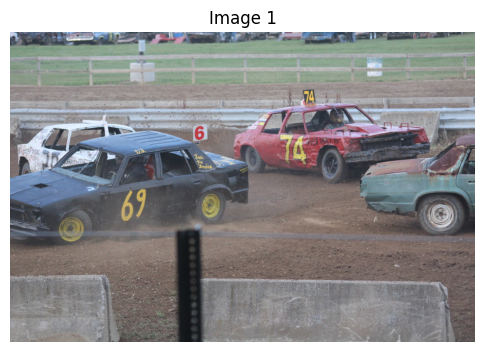

Ground Truth: In this picture we can see people driving old cars on the ground covered with mud and surrounded by barricades, metal poles, fence, divider, wooden fence, poles etc., We can see some text and numbers on the cars. In the background, we can see grass, poles and other vehicles on the ground.
LLaVA Prediction: The image captures a thrilling scene of two cars racing on a dirt track. The cars are positioned close to each other, with one car slightly ahead of the other. The cars are in motion, kicking up dirt as they speed along the track.

There are several people in the scene, likely spectators or participants in the race. Some of them are standing near the cars, while others are scattered around the track. The atmosphere is lively, with everyone enjo

Individual Metric Scores:
  ROUGE-1 F1: 0.1970
  ROUGE-2 F1: 0.0308
  ROUGE-L F1: 0.1515
  BLEU Score: 1.3840
  Semantic Similarity: 0.5824
  CIDEr Score: 0.0247
  METEOR Score: 0.0667
  BERTScore F1: 0.8519
  SPICE-like Score: 

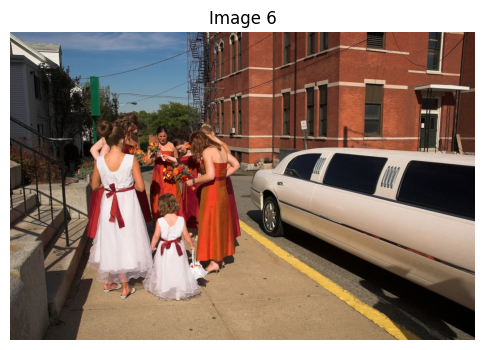

Ground Truth: In this picture I can see a car on the road, it is white in color. I can see few women standing, few are holding flowers and looks like a small girl holding a basket. I can see the stairs and metal railing on the left side. I can see the buildings on the left side and on the right side of the picture, looks like a pole light in the back and I can see a pole on the left side. I can see the metal stairs on the right side and the sky at the top.
LLaVA Prediction: The image features a group of women dressed in red and orange gowns, standing on a sidewalk near a white stretch limousine. They are gathered around the limousine, possibly preparing for a special event or celebration. The women are engaged in conversation and enjoying each other's company.

In addition to the limousine, there is a car parked further back in the scene. The women are carrying handbags, with one handbag located near

Individual Metric Scores:
  ROUGE-1 F1: 0.2924
  ROUGE-2 F1: 0.0237
  ROUGE-L F1: 0.1

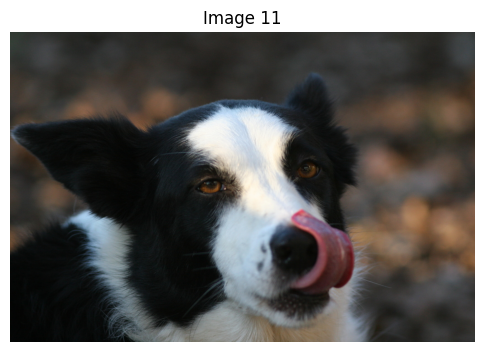

Ground Truth: In this picture I can see a dog. There is blur background.
LLaVA Prediction: The image features a black and white dog with a pink tongue sticking out of its mouth. The dog appears to be licking its nose, giving the impression that it is licking itself. The dog is looking directly at the camera, capturing the viewer's attention. The scene is set in a dirt field, adding a natural element to the image.

Individual Metric Scores:
  ROUGE-1 F1: 0.1096
  ROUGE-2 F1: 0.0000
  ROUGE-L F1: 0.0822
  BLEU Score: 0.8073
  Semantic Similarity: 0.5495
  CIDEr Score: 0.0109
  METEOR Score: 0.0571
  BERTScore F1: 0.8746
  SPICE-like Score: 0.1111
  Content Word Overlap: 0.0645
------------------------------

--- Example 16 ---


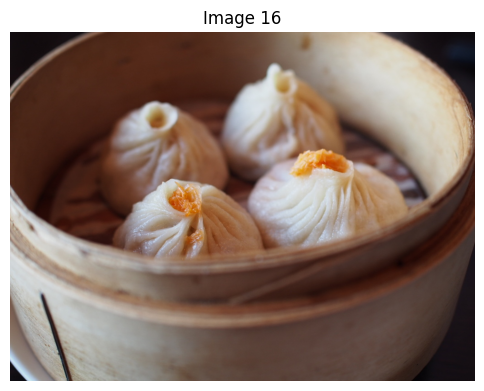

Ground Truth: In this image we can see some food in a circular wooden box.
LLaVA Prediction: The image features a wooden bowl filled with four delicious-looking dumplings. These dumplings are steamed and have a golden-brown color, indicating that they are freshly cooked. The bowl is placed on a dining table, and the dumplings are arranged in a visually appealing manner. The table setting creates an inviting atmosphere for enjoying these tasty treats.

Individual Metric Scores:
  ROUGE-1 F1: 0.1127
  ROUGE-2 F1: 0.0290
  ROUGE-L F1: 0.0845
  BLEU Score: 1.4699
  Semantic Similarity: 0.4201
  CIDEr Score: 0.0192
  METEOR Score: 0.1053
  BERTScore F1: 0.8713
  SPICE-like Score: 0.1111
  Content Word Overlap: 0.1176
------------------------------

--- Example 21 ---


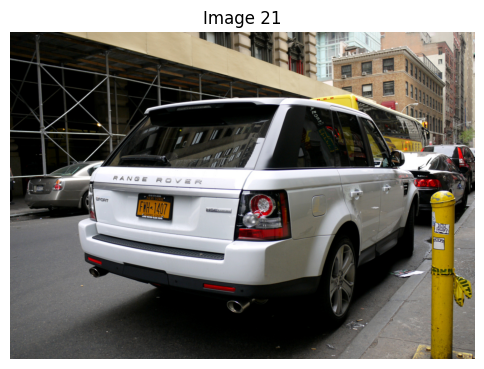

Ground Truth: In the picture I can see the vehicles on the road. There is a pole on the bottom right side of the picture. I can see the light poles on the side of the road. In the background, I can see the buildings.
LLaVA Prediction: The image features a white Range Rover parked on a city street. The car is positioned in the middle of the scene, and it appears to be the main focus of the image.

There are several other cars parked around the white Range Rover, with one car on the left side, another on the right side, and a third car further back on the right side. Additionally, there is a bus located in the background, slightly to the right of the white Range R

Individual Metric Scores:
  ROUGE-1 F1: 0.3780
  ROUGE-2 F1: 0.1760
  ROUGE-L F1: 0.2520
  BLEU Score: 3.6906
  Semantic Similarity: 0.5806
  CIDEr Score: 0.0783
  METEOR Score: 0.0870
  BERTScore F1: 0.8747
  SPICE-like Score: 0.2619
  Content Word Overlap: 0.1290
------------------------------


In [65]:
# Recalculate better metrics with a smaller batch size for BERTScore
better_metrics = calculate_better_metrics(
    test_df['llava_prediction'].tolist(),
    test_df['text'].tolist(),
    bertscore_batch_size=8  # Reduced batch size
)

# Now display the metrics for the selected examples
example_indices = [0, 5, 10, 15, 20]

for i in example_indices:
    print(f"\n--- Example {i+1} ---")

    # Display Image (re-display for context)
    image_bytes = test_df.iloc[i]['image']['bytes']
    image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Image {i+1}")
    plt.axis('off')
    plt.show()

    # Display Captions
    ground_truth = test_df.iloc[i]['text']
    prediction = test_df.iloc[i]['llava_prediction']
    print(f"Ground Truth: {ground_truth}")
    print(f"LLaVA Prediction: {prediction}")

    # Display Metrics for this example
    print("\nIndividual Metric Scores:")
    print(f"  ROUGE-1 F1: {rouge_scores['rouge1'][i]:.4f}")
    print(f"  ROUGE-2 F1: {rouge_scores['rouge2'][i]:.4f}")
    print(f"  ROUGE-L F1: {rouge_scores['rougeL'][i]:.4f}")
    print(f"  BLEU Score: {bleu_scores[i]:.4f}")
    print(f"  Semantic Similarity: {semantic_scores[i]:.4f}")
    print(f"  CIDEr Score: {better_metrics['cider'][i]:.4f}")
    print(f"  METEOR Score: {better_metrics['meteor'][i]:.4f}")
    print(f"  BERTScore F1: {better_metrics['bertscore'][i]:.4f}")
    print(f"  SPICE-like Score: {better_metrics['spice_like'][i]:.4f}")
    print(f"  Content Word Overlap: {better_metrics['cwo'][i]:.4f}")

    print("-" * 30)


--- Example 26 ---


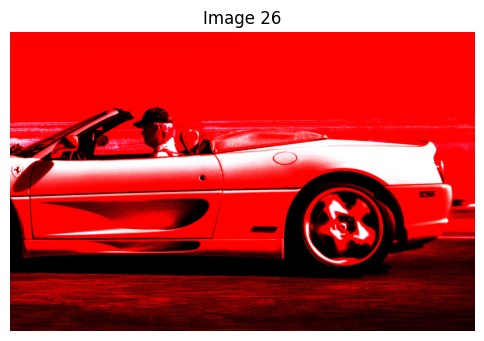

Ground Truth: This is an edited image. In which we can see a person in the car. At the bottom, there is a road. The background is in red color.
LLaVA Prediction: The image features a man driving a white sports car on a road. He is wearing a hat and appears to be enjoying the ride. The car is a convertible, allowing the driver to enjoy the open air. The man is seated in the driver's seat, and the car is positioned in the center of the scene.

Individual Metric Scores:
  ROUGE-1 F1: 0.3023
  ROUGE-2 F1: 0.0952
  ROUGE-L F1: 0.2093
  BLEU Score: 4.4085
  Semantic Similarity: 0.5592
  CIDEr Score: 0.0465
  METEOR Score: 0.1667
  BERTScore F1: 0.8844
  SPICE-like Score: 0.1429
  Content Word Overlap: 0.2000
------------------------------

--- Example 31 ---


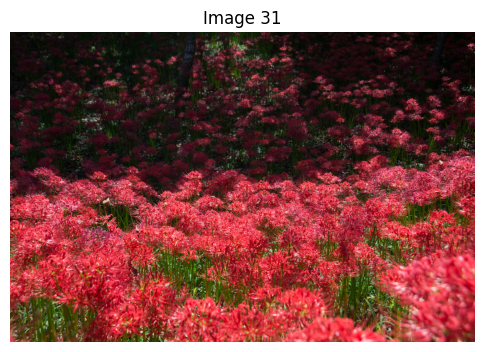

Ground Truth: In the image there are many plants with flowers and leaves.
LLaVA Prediction: The image features a lush, red flower field with a variety of red flowers scattered throughout the scene. The flowers are of different sizes and shapes, creating a vibrant and colorful display. The field is surrounded by a forest, adding to the natural beauty of the scene. The combination of the red flowers and the forest creates a serene and picturesque landscape.

Individual Metric Scores:
  ROUGE-1 F1: 0.1644
  ROUGE-2 F1: 0.0563
  ROUGE-L F1: 0.1370
  BLEU Score: 1.4330
  Semantic Similarity: 0.6063
  CIDEr Score: 0.0296
  METEOR Score: 0.1053
  BERTScore F1: 0.8823
  SPICE-like Score: 0.1667
  Content Word Overlap: 0.1379
------------------------------

--- Example 36 ---


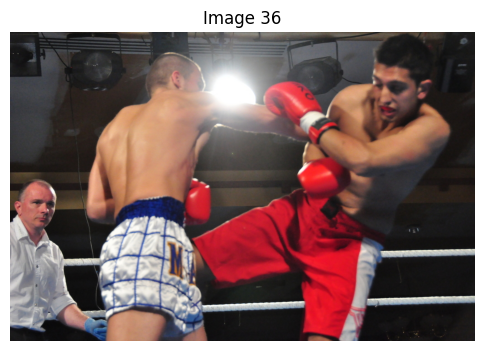

Ground Truth: In this image I can see two people boxing in the boxing ring. On the left side I can see a person. In the background, I can see the light and the wall.
LLaVA Prediction: The image captures a boxing match between two men, both wearing red shorts. One of the men is in the process of throwing a punch, while the other man is trying to block the punch. The boxers are focused on their opponent, displaying their skills and determination.

The scene takes place in a boxing ring, with a bench visible in the background. The boxers are equipped with gloves, which can be seen on their hands

Individual Metric Scores:
  ROUGE-1 F1: 0.3333
  ROUGE-2 F1: 0.0755
  ROUGE-L F1: 0.2037
  BLEU Score: 1.9805
  Semantic Similarity: 0.7502
  CIDEr Score: 0.0483
  METEOR Score: 0.1778
  BERTScore F1: 0.8861
  SPICE-like Score: 0.6481
  Content Word Overlap: 0.2000
------------------------------

--- Example 41 ---


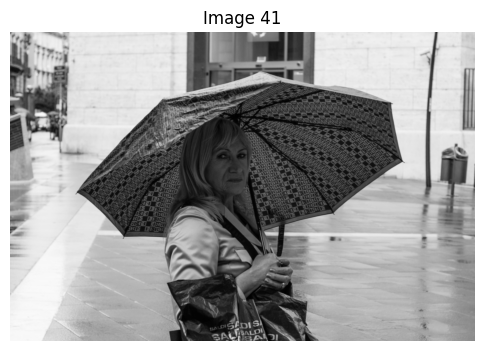

Ground Truth: This is a black and white picture. In this picture we can see a woman carrying a bag and holding an umbrella. In the background we can see the ground, dustbins, boards, trees, buildings and some objects.
LLaVA Prediction: The image features a woman sitting on a bench, holding an umbrella to protect herself from the rain. She is wearing a white shirt and appears to be looking at the camera. The umbrella is open, covering her from the rain.

There are a few other people in the scene, but they are not the main focus. The woman with the umbrella is the central figure in the image.

Individual Metric Scores:
  ROUGE-1 F1: 0.2642
  ROUGE-2 F1: 0.0769
  ROUGE-L F1: 0.1698
  BLEU Score: 3.0195
  Semantic Similarity: 0.7154
  CIDEr Score: 0.0424
  METEOR Score: 0.1818
  BERTScore F1: 0.8718
  SPICE-like Score: 0.1717
  Content Word Overlap: 0.2105
------------------------------

--- Example 46 ---


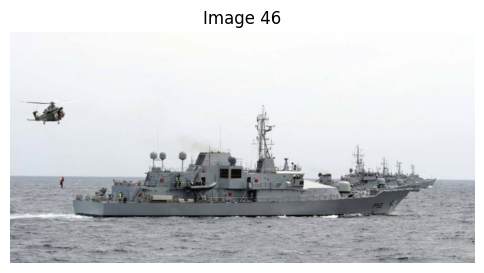

Ground Truth: This image is taken outdoors. At the top of the image there is sky. At the bottom of the image there is the sea. In the middle of the image there is a ship on the sea. There are few people on the ship. On the left side of the image there is a chopper flying in the sky. A person is hanging by a rope.
LLaVA Prediction: The image features a large gray boat floating on the water. The boat is surrounded by a few smaller boats, with one boat located to the left and another to the right. The main boat appears to be a large ship, possibly a warship, as it is equipped with a radar system. The radar system is mounted on the top of the boat, and it is clearly visible in the scene.

Individual Metric Scores:
  ROUGE-1 F1: 0.4088
  ROUGE-2 F1: 0.1333
  ROUGE-L F1: 0.2628
  BLEU Score: 5.8832
  Semantic Similarity: 0.5311
  CIDEr Score: 0.0850
  METEOR Score: 0.1132
  BERTScore F1: 0.8841
  SPICE-like Score: 0.0833
  Content Word Overlap: 0.1579
------------------------------


In [105]:
import io

# Select additional example indices
example_indices_additional = [25, 30, 35, 40, 45]

for i in example_indices_additional:
    print(f"\n--- Example {i+1} ---")

    # Display Image
    image_bytes = test_df.iloc[i]['image']['bytes']
    image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Image {i+1}")
    plt.axis('off')
    plt.show()

    # Display Captions
    ground_truth = test_df.iloc[i]['text']
    prediction = test_df.iloc[i]['llava_prediction']
    print(f"Ground Truth: {ground_truth}")
    print(f"LLaVA Prediction: {prediction}")

    # Display Metrics for this example
    print("\nIndividual Metric Scores:")
    print(f"  ROUGE-1 F1: {rouge_scores['rouge1'][i]:.4f}")
    print(f"  ROUGE-2 F1: {rouge_scores['rouge2'][i]:.4f}")
    print(f"  ROUGE-L F1: {rouge_scores['rougeL'][i]:.4f}")
    print(f"  BLEU Score: {bleu_scores[i]:.4f}")
    print(f"  Semantic Similarity: {semantic_scores[i]:.4f}")
    print(f"  CIDEr Score: {better_metrics['cider'][i]:.4f}")
    print(f"  METEOR Score: {better_metrics['meteor'][i]:.4f}")
    print(f"  BERTScore F1: {better_metrics['bertscore'][i]:.4f}") # Include BERTScore
    print(f"  SPICE-like Score: {better_metrics['spice_like'][i]:.4f}")
    print(f"  Content Word Overlap: {better_metrics['cwo'][i]:.4f}")

    print("-" * 30)

## 6. Summary and Conclusion

### Summary of Evaluation Results

Based on the evaluation metrics and the analysis of individual examples, here is a summary of the LLaVA model's performance on the image captioning task:

**Overall Metrics:**

*   **Traditional Metrics (ROUGE, BLEU):** These metrics show relatively low scores, which is common for generative tasks like image captioning where there can be many valid ways to describe an image. ROUGE-1 and ROUGE-L, which measure unigram and longest common subsequence overlap respectively, are higher than ROUGE-2, indicating that the model captures some of the key words and phrases but struggles with capturing longer sequences of words accurately compared to the ground truth. The low BLEU score also suggests a lack of exact n-gram overlap with the reference captions.

*   **Semantic Similarity (Sentence-BERT):** The moderate semantic similarity score indicates that while the generated captions may not use the exact same words or phrases as the ground truth, they often convey a similar overall meaning.

*   **Advanced Metrics (CIDEr, METEOR, BERTScore, SPICE-like, CWO):**
    *   **BERTScore:** Shows a relatively high score, suggesting that the generated captions are contextually similar to the ground truth at a deeper level, even if the exact words differ.
    *   **METEOR:** A moderate score indicates some level of alignment between the generated and reference captions, considering synonyms and paraphrases.
    *   **CIDEr:** The low CIDEr score suggests that the generated captions do not align strongly with the consensus of human-written captions in terms of n-gram overlap, especially when considering the TF-IDF weighting.
    *   **SPICE-like and CWO:** These scores, which focus on semantic content and important word overlap, are also relatively low, indicating that the model might miss some specific objects, attributes, or relationships present in the ground truth captions.

**Insights from Individual Examples:**

*   Looking at individual examples confirms that the model often generates plausible descriptions, but they may lack the specific details or perspectives present in the ground truth captions.
*   In some cases, the model might hallucinate objects or actions that are not actually in the image (e.g., describing people racing when the image shows parked cars).
*   The model sometimes focuses on prominent aspects of the image while missing more subtle details mentioned in the ground truth.
*   The variation in individual metric scores highlights that the model's performance can vary depending on the complexity and content of the image.

**Conclusion:**

The LLaVA model demonstrates some capability in generating semantically relevant image captions, as indicated by the semantic similarity and BERTScore. However, the lower scores on metrics that rely more on exact word overlap and capturing specific details suggest that there is room for improvement in generating captions that are both fluent and highly aligned with human descriptions at a granular level. Further fine-tuning or exploring different prompting strategies could potentially improve the model's performance on these aspects.